<a href="https://colab.research.google.com/github/dokyunner/wassup13/blob/main/0224_Sprint2_Part3_%EC%9B%B9_%EC%8A%A4%ED%81%AC%EB%9E%98%ED%95%91_%EA%B8%B0%EC%B4%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint2_Part3_웹 스크래핑 기초  
> 목표: 기본적인 웹 스크래핑으로 데이터를 수집해보고 분석하는 과정을 파악한다.  
> 내용: 웹 스크래핑 기초, selenium / BeautifulSoup, 키워드 분석, wordcluod

> selenium  
-> 직접 웹 페이지를 방문하여 요소 수집, 동적 웹 스크래핑 가능  
BeautifulSoup  
-> HTML 파싱만으로 간단하고 빠른 수집, 정적 웹 스크래핑에 적합  

>selenium, BeautifulSoup 결합 웹 스크래핑  
selenium으로 동적 웹 요소 조회, BeautifulSoup으로 조회된 요소 빠르게 데이터화  

>예시 사이트 리뷰, 댓글, 좋아요, 아이디 등 데이터 특징별 요소 추출하여 df 생성  
생성된 df로 워드 클라우드 생성, 불용어 설정 후 워드 클라우드 키워드 분석 및 인사이트 도출 실습

In [4]:
!wget -q -O - https://dl.google.com/linux/linux_signing_key.pub | apt-key add - && \
    sh -c 'echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" >> /etc/apt/sources.list.d/google-chrome.list' && \
    apt-get update && \
    apt-get install -y google-chrome-stable && \
    rm -rf /var/lib/apt/lists/*

OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1,825 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cli.github.com/packages stable InRelease [3,917 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:10 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1,212 B]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,737 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [62.6 k

In [5]:
!google-chrome --version

Google Chrome 145.0.7632.116 


1. chrome 브라우저 실행 - 우측 상단 점 세개 더보기 클릭 - 설정 - 제일 하단 chrome 정보 버전 확인  
2. [코랩에 맞는 linux 버전 크롬 드라이버 설치](https://storage.googleapis.com/chrome-for-testing-public/145.0.7632.76/linux64/chromedriver-linux64.zip)
  압축파일 다운로드 (버전 업데이트시 [해당 사이트](https://googlechromelabs.github.io/chrome-for-testing/#stable) 확인)  

3.   다운로드 된 파일 압축 해제 후, chromedriver 파일을 코랩 폴더에 드래그하여 옮기기 (코랩 좌측 폴더아이콘 클릭)

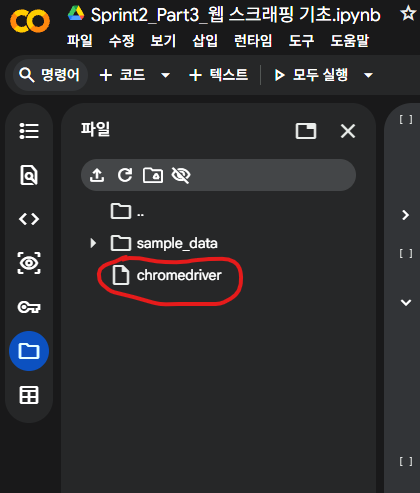

In [6]:
!chmod +x /content/chromedriver

In [7]:
!pip install selenium==4.40.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0


In [8]:
import re, time
import urllib.request
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from wordcloud import WordCloud

In [9]:
# timesleep 설정
slp = np.random.uniform(2, 4) # 2~4초 사이 랜덤 대기
slp_s = np.random.uniform(1, 2) # 1~2초 사이 랜덤 대기
slp_l = np.random.uniform(4, 6) # 4~6초 사이 랜덤 대기

limit = 20 # 더보기 버튼 클릭 함수 (최대 20번으로 제한, 늘리거나 줄일 수 있음)

def click_more(page_name):
    if page_name == 'movie':
        more_selector = '.discovery__actions button'
    elif page_name == 'review':
        more_selector = '.button-wrap rt-button'
    cnt = 0
    while cnt < limit:
        try:
            r_more = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, more_selector))
            )
            driver.execute_script("arguments[0].scrollIntoView({block:'center'});", r_more)
            time.sleep(slp_s)  # 스크롤 후 잠시 대기
            r_more.click()
            time.sleep(slp)  # 클릭 후 랜덤한 시간 대기
            cnt += 1
            print(f'더보기 {cnt}회 클릭')
        except:
            break

In [11]:
# Selenium 옵션 설정
options = Options()
options.add_argument('--headless=new')
options.add_argument('--no-sandbox')
options.add_argument("window-size=1240x1080")
options.add_argument("disable-gpu")
options.add_argument('--disable-dev-shm-usage')

# Service 객체로 ChromeDriver 경로 지정


# 스트리밍 순위 페이지 (평론가점수, 관객점수 기준)
BROWSE_url = "https://www.rottentomatoes.com/browse/movies_at_home/audience:verified_hot~critics:certified_fresh"

# Selenium으로 웹페이지 열기
service = Service(executable_path="/content/chromedriver")
driver = webdriver.Chrome(service=service, options=options)
driver.get(BROWSE_url) # 영화목록 or 리뷰페이지 url
time.sleep(slp_l)

# cookie_accept 클릭
cookie_accept= driver.find_element(By.CSS_SELECTOR,'#onetrust-accept-btn-handler').click()
time.sleep(slp_s)

# 더보기 클릭
click_more('movie')
time.sleep(slp_s)

# 페이지 소스 가져오기
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')
driver.close()

더보기 1회 클릭
더보기 2회 클릭
더보기 3회 클릭
더보기 4회 클릭
더보기 5회 클릭


In [12]:
# 영화 제목과 개봉일 추출
m_title = soup.select("span[data-qa='discovery-media-list-item-title']")
m_date = soup.select("span[data-qa='discovery-media-list-item-start-date']")

m_title_li = [m_title[i].text.strip() for i in range(len(m_title))]
m_date_li = [m_date[i].text.strip() for i in range(len(m_date))]
len(f'{m_title_li} title'), len(f'{m_date_li} date')

# 평론가와 관객 점수 추출
c_score = soup.select("score-pairs-deprecated rt-text[slot='criticsScore']")
a_score = soup.select("score-pairs-deprecated rt-text[slot='audienceScore']")

c_score_li = [c_score[i].text for i in range(len(c_score))]
a_score_li = [a_score[i].text for i in range(len(a_score))]
len(f'{c_score_li} criticsScores'), len(f'{a_score_li} audienceScores')

# df변환 후 csv 저장
df = pd.DataFrame(columns=['title', 'date', 'critics_score(%)', 'audience_score(%)'],
                  data=list(zip(m_title_li, m_date_li, c_score_li, a_score_li)))
os.makedirs('./rank_df', exist_ok=True)  # 하위경로에 rank_df 폴더 생성
df.to_csv('./rank_df/rt_stream_rank.csv', index=False)
print('rt_stream_rank.csv 저장 완료')

# 영화 포스터 이미지 png 저장
imgs = soup.select("rt-img.posterImage")
image_urls = [img["src"] for img in imgs]
len(f'{image_urls} images')

url = image_urls[0]
for i in range(len(image_urls)):
    os.makedirs('./posters', exist_ok=True)  # 하위경로에 posters 폴더 생성
    safe_title = re.sub(r'[\\/:*?"<>|]', '', m_title_li[i]).strip()
    urllib.request.urlretrieve(image_urls[i], f"./posters/{safe_title}poster_{i+1}.png")
    print(f'{i+1}개 포스터 저장 완료')

rt_stream_rank.csv 저장 완료
1개 포스터 저장 완료
2개 포스터 저장 완료
3개 포스터 저장 완료
4개 포스터 저장 완료
5개 포스터 저장 완료
6개 포스터 저장 완료
7개 포스터 저장 완료
8개 포스터 저장 완료
9개 포스터 저장 완료
10개 포스터 저장 완료
11개 포스터 저장 완료
12개 포스터 저장 완료
13개 포스터 저장 완료
14개 포스터 저장 완료
15개 포스터 저장 완료
16개 포스터 저장 완료
17개 포스터 저장 완료
18개 포스터 저장 완료
19개 포스터 저장 완료
20개 포스터 저장 완료
21개 포스터 저장 완료
22개 포스터 저장 완료
23개 포스터 저장 완료
24개 포스터 저장 완료
25개 포스터 저장 완료
26개 포스터 저장 완료
27개 포스터 저장 완료
28개 포스터 저장 완료
29개 포스터 저장 완료
30개 포스터 저장 완료
31개 포스터 저장 완료
32개 포스터 저장 완료
33개 포스터 저장 완료
34개 포스터 저장 완료
35개 포스터 저장 완료
36개 포스터 저장 완료
37개 포스터 저장 완료
38개 포스터 저장 완료
39개 포스터 저장 완료
40개 포스터 저장 완료
41개 포스터 저장 완료
42개 포스터 저장 완료
43개 포스터 저장 완료
44개 포스터 저장 완료
45개 포스터 저장 완료
46개 포스터 저장 완료
47개 포스터 저장 완료
48개 포스터 저장 완료
49개 포스터 저장 완료
50개 포스터 저장 완료
51개 포스터 저장 완료
52개 포스터 저장 완료
53개 포스터 저장 완료
54개 포스터 저장 완료
55개 포스터 저장 완료
56개 포스터 저장 완료
57개 포스터 저장 완료
58개 포스터 저장 완료
59개 포스터 저장 완료
60개 포스터 저장 완료
61개 포스터 저장 완료
62개 포스터 저장 완료
63개 포스터 저장 완료
64개 포스터 저장 완료
65개 포스터 저장 완료
66개 포스터 저장 완료
67개 포스터 저장 완료
68개 포스터 저장 완료
69개 포스터 저장 완료
70개 포스터 저장 완료
71개 

In [37]:
# 원하는 콘텐츠의 순위 확인

df[df['title'] == 'Inside Out']

,title,date,critics_score(%),audience_score(%)


In [15]:
# 리뷰페이지 url 지정
movie_name = 'zootopia_2' # url내 영화이름
review_url = f"https://www.rottentomatoes.com/m/{movie_name}/reviews/all-audience"

# Selenium으로 웹페이지 열기
driver = webdriver.Chrome(options=options)
driver.get(review_url)
time.sleep(slp_l)

# cookie_accept 클릭
cookie_accept= driver.find_element(By.CSS_SELECTOR,'#onetrust-accept-btn-handler').click()
time.sleep(slp_s)

# 리뷰 더보기 클릭
click_more('review')
time.sleep(slp_s)

# 페이지 소스 가져오기
html = driver.page_source
soup = BeautifulSoup(html, 'lxml')
driver.close()

더보기 1회 클릭
더보기 2회 클릭
더보기 3회 클릭
더보기 4회 클릭
더보기 5회 클릭
더보기 6회 클릭
더보기 7회 클릭
더보기 8회 클릭
더보기 9회 클릭
더보기 10회 클릭
더보기 11회 클릭
더보기 12회 클릭
더보기 13회 클릭
더보기 14회 클릭
더보기 15회 클릭
더보기 16회 클릭
더보기 17회 클릭
더보기 18회 클릭
더보기 19회 클릭
더보기 20회 클릭


In [16]:
# 리뷰 작성자, 날짜, 평점, 리뷰 내용 추출

print(soup.select('rt-link[slot="name"]')[0].text.strip()) # 리뷰 작성자
print(soup.select('span[slot="timestamp"]')[0].text.strip()) # 리뷰 날짜
print(soup.select('rating-stars-group')[0].get('score')) # 리뷰 평점
print(soup.select('span[slot="content"]')[0].text.strip()) # 리뷰 내용

nickname = soup.select('rt-link[slot="name"]')
time_ago = soup.select('span[slot="timestamp"]')
rating = soup.select('rating-stars-group')
content_txt = soup.select('span[slot="content"]')

nicknames = [nickname[i].text.strip() for i in range(len(nickname))]
time_ago_li = [time_ago[i].text.strip() for i in range(len(time_ago))]
rating_li = [rating[i].get('score') for i in range(len(rating))]
content_li = [content_txt[i].text.strip() for i in range(len(content_txt))]

df_review = pd.DataFrame(columns=['nickname', 'time_ago', 'rating', 'content_txt'],
                         data=list(zip(nicknames, time_ago_li, rating_li, content_li)))

os.makedirs('./review_df', exist_ok=True)  # 하위경로에 review_df 폴더 생성
df_review.to_csv(f'./review_df/{movie_name}_reviews.csv', index=False)

Rodney
23h
3
Enjoyable but the first was far better


In [17]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nickname     410 non-null    object
 1   time_ago     410 non-null    object
 2   rating       410 non-null    object
 3   content_txt  410 non-null    object
dtypes: object(4)
memory usage: 12.9+ KB


In [18]:
df_review.describe(exclude=['number'])

,nickname,time_ago,rating,content_txt
count,410,410,410,410
unique,403,44,10,410
top,Jamie,Jan 20,5,"I adored this! Super funny, great fun!"
freq,2,20,230,1


In [19]:
df_review['rating'] = df_review['rating'].astype(float)
df_review.describe()

,rating
count,410.000000
mean,4.380488
std,0.991583
min,0.500000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [20]:
# 평균 평점
df_review["rating"].mean().round(2)

np.float64(4.38)

In [21]:
# 평점 중앙값
df_review["rating"].astype(float).median()

5.0

In [22]:
df_review["rating"].value_counts().sort_index()


,count
rating,
0.5,5
1.0,6
1.5,7
2.0,8
2.5,5
3.0,12
3.5,20
4.0,68
4.5,49


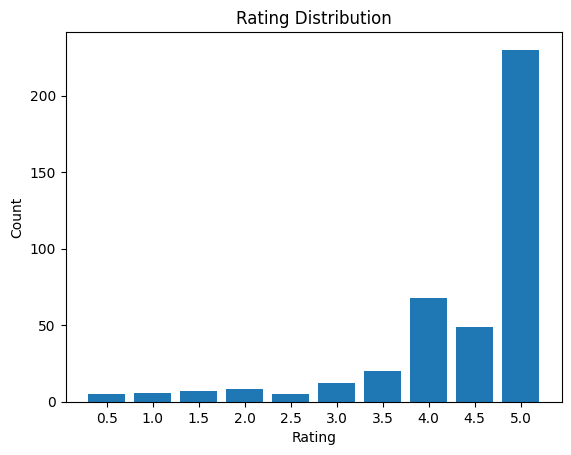

In [23]:
import matplotlib.pyplot as plt

rating_counts = df_review["rating"].value_counts().sort_index()

plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()


In [24]:
# 긍 부정 리뷰 분석
positive = df_review[df_review["rating"] >= 4]
negative = df_review[df_review["rating"] <= 2]

df_review["review_len"] = df_review["content_txt"].apply(len)

# 4~5점 평균 글자수
positive_avg_len = df_review[df_review["rating"] >= 4]['review_len'].mean()

# 1~2점 평균 글자수
negative_avg_len = df_review[df_review["rating"] <= 2]["review_len"].mean()

print("4~5점 평균 글자수:", round(positive_avg_len, 2))
print("1~2점 평균 글자수:", round(negative_avg_len, 2))
print("긍정 비율:", round(len(positive) / len(df_review), 2))
print("부정 비율:", round(len(negative) / len(df_review), 2))


4~5점 평균 글자수: 153.68
1~2점 평균 글자수: 225.96
긍정 비율: 0.85
부정 비율: 0.06


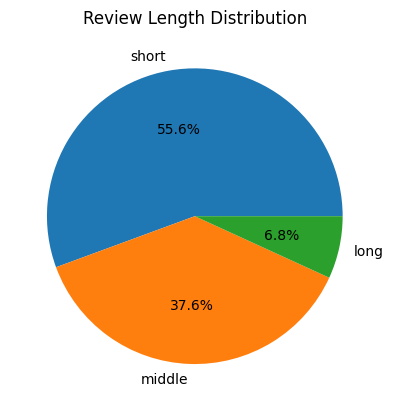

In [25]:
# 리뷰 길이별 분포
df_review["review_lencat"] = ['long' if txt > 500 else 'middle' if txt > 100 else 'short' for txt in df_review["content_txt"].astype(str).apply(len)]

plt.figure()
plt.pie(df_review["review_lencat"].value_counts(), labels=df_review["review_lencat"].value_counts().index,  autopct='%1.1f%%')
plt.title("Review Length Distribution")
plt.show()


In [26]:
# 별점 별 리뷰 글자 수 분석

df_review.groupby("rating")["review_len"].agg(["count", "mean", "median", "max", "min"]).round(2)

,count,mean,median,max,min
rating,,,,,
0.5,5,115.40,116.0,211,16
1.0,6,115.17,126.0,203,22
1.5,7,399.57,421.0,726,50
2.0,8,226.25,48.0,1127,21
2.5,5,274.20,198.0,675,36
3.0,12,208.75,168.5,900,29
3.5,20,309.25,271.0,939,43
4.0,68,175.50,87.0,1702,20
4.5,49,248.82,138.0,3204,22


In [27]:
# 긍부정 분류

#4~5점 리뷰 텍스트
po_text = " ".join(df_review[df_review["rating"] >= 4]["content_txt"])
#1~2점 리뷰 텍스트
ne_text = " ".join(df_review[df_review["rating"] <= 2]["content_txt"])

In [28]:
# 주토피아2 리뷰 키워드 분석 (wordcloud)

txts_li = df_review['content_txt'].tolist()
txts_li = [txt.lower() for txt in txts_li] # 소문자 변환
txts_li = [re.sub(r'[^a-z\s]', ' ', txt) for txt in txts_li] # 특수문자 제거 (영문과 공백 제외)
txts_li = [re.sub(r'\s+', ' ', txt).strip() for txt in txts_li] # 다중 공백 제거 및 양쪽 공백 제거

# 기본 불용어 지정
stopwords = set(WordCloud().stopwords)
basic_stopwords = {"the","a","an","and","or","but","to","of","in","on","for","with","as","at",
                    "is","it","this","that","was","were","are","be","been","being",
                    "i","you","we","they","he","she","my","your","our","their",
                    "movie","film", "zootopia", "good", "great"}

In [29]:
from collections import Counter

all_words = " ".join(txts_li).split()

filtered_words = [w for w in all_words if w not in basic_stopwords and len(w) > 2]

word_freq = Counter(filtered_words)

# 상위 빈도 20개 키워드 확인
top20 = word_freq.most_common(20)
top20


[('first', 113),
 ('one', 84),
 ('loved', 75),
 ('like', 69),
 ('fun', 67),
 ('story', 57),
 ('really', 56),
 ('characters', 52),
 ('not', 49),
 ('all', 47),
 ('sequel', 47),
 ('funny', 47),
 ('very', 47),
 ('just', 46),
 ('enjoyed', 46),
 ('kids', 45),
 ('disney', 42),
 ('better', 41),
 ('watch', 41),
 ('than', 41)]

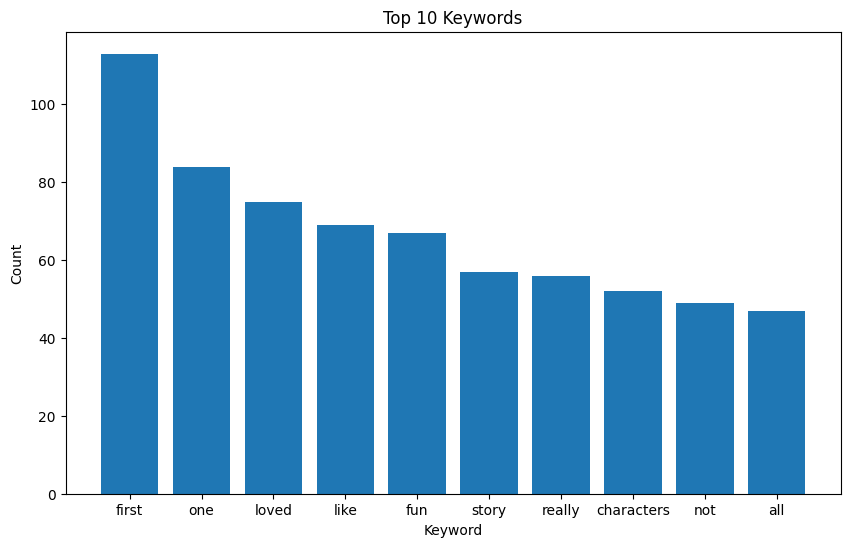

In [30]:
import matplotlib.pyplot as plt

top10 = top20[:10]

words = [item[0] for item in top10]
counts = [item[1] for item in top10]

plt.figure(figsize=(10,6))
plt.bar(words, counts)
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.title("Top 10 Keywords")
plt.show()


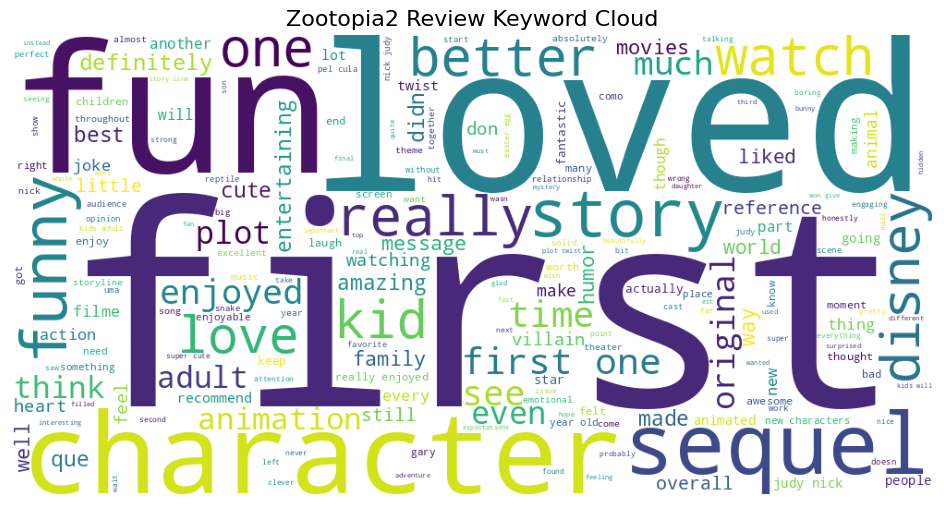

In [31]:
text = " ".join(filtered_words)

wc = WordCloud(
    width=1000,
    height=500,
    background_color="white"
).generate(text)

plt.figure(figsize=(14,6))
plt.imshow(wc)
plt.axis("off")
plt.title("Zootopia2 Review Keyword Cloud", fontsize=16)
plt.show()


In [34]:
# 함수로 지정하여 다양하게 분석할 수 있음

def review_sentiment_analysis(df, text_col="content_txt", rating_col="rating",
                              extra_stopwords=None, movie_name=None):

    # 그룹 정의
    groups = {
        "All Reviews": df,
        "Positive (4-5)": df[df[rating_col] >= 4],
        "Negative (1-2)": df[df[rating_col] <= 2]
    }

    # 불용어 설정
    default_stopwords = set(WordCloud().stopwords)

    basic_stopwords = {
        "the","a","an","and","or","but","to","of","in","on","for","with","as","at",
        "is","it","this","that","was","were","are","be","been","being",
        "i","you","we","they","he","she","my","your","our","their",
        "movie","film"
    }

    if movie_name:
        basic_stopwords.add(movie_name.lower())

    stopwords = default_stopwords.union(basic_stopwords)

    if extra_stopwords:
        stopwords = stopwords.union(extra_stopwords)


    # 그룹별 분석
    for label, data in groups.items():

        if len(data) == 0:
            print(f"\n {label} 데이터 없음")
            continue

        print("\n" + "="*50)
        print(f"{label}")

        texts = data[text_col].astype(str).tolist()

        # 전처리
        texts = [txt.lower() for txt in texts]
        texts = [re.sub(r'[^a-z\s]', ' ', txt) for txt in texts]
        texts = [re.sub(r'\s+', ' ', txt).strip() for txt in texts]

        # 평균 길이
        avg_len = sum(len(txt) for txt in texts) / len(texts)
        print("평균 리뷰 길이:", round(avg_len,1))

        # 단어 분리
        words = " ".join(texts).split()
        filtered = [w for w in words if w not in stopwords and len(w) > 2]

        # 빈도 계산
        freq = Counter(filtered)
        top10 = freq.most_common(10)

        print("상위 키워드 10개:")
        print(top10)

        # 막대그래프
        words_plot = [item[0] for item in top10]
        counts_plot = [item[1] for item in top10]

        plt.figure(figsize=(8,4))
        plt.bar(words_plot, counts_plot)
        plt.xticks(rotation=45)
        plt.title(f"{label} Top Keywords")
        plt.show()

        # 워드클라우드
        wc = WordCloud(width=900, height=450,
                       background_color="white").generate(" ".join(filtered))

        plt.figure(figsize=(12,5))
        plt.imshow(wc)
        plt.axis("off")
        plt.title(f"{label} WordCloud")
        plt.show()


All Reviews
평균 리뷰 길이: 163.6
상위 키워드 10개:
[('loved', 75), ('fun', 67), ('story', 57), ('really', 56), ('characters', 52), ('sequel', 47), ('funny', 47), ('enjoyed', 46), ('kids', 45), ('disney', 42)]


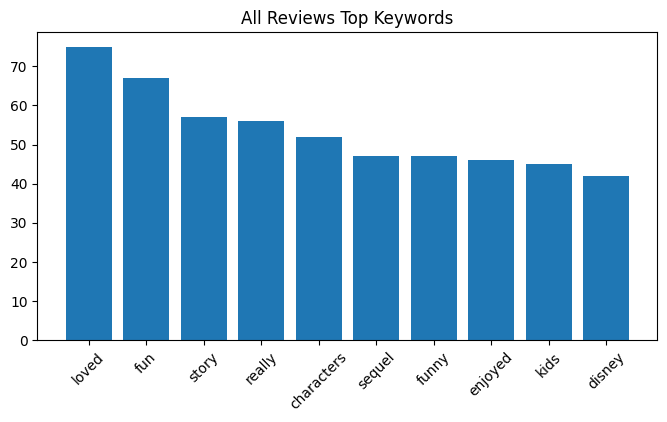

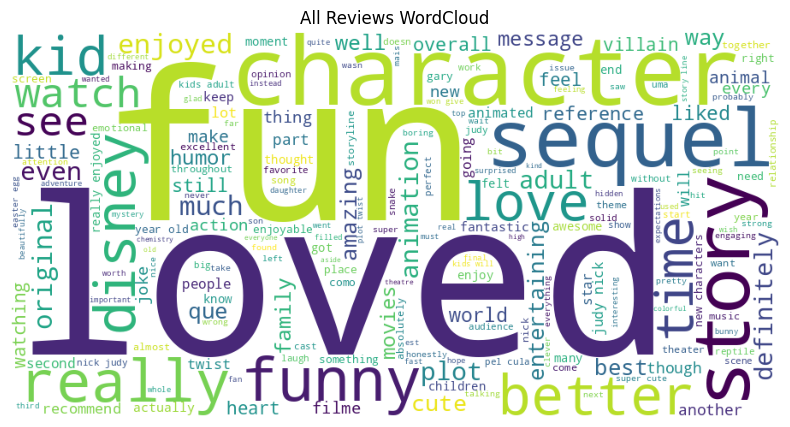


Positive (4-5)
평균 리뷰 길이: 148.8
상위 키워드 10개:
[('loved', 70), ('fun', 60), ('really', 49), ('story', 46), ('characters', 45), ('enjoyed', 41), ('kids', 39), ('sequel', 39), ('love', 37), ('funny', 36)]


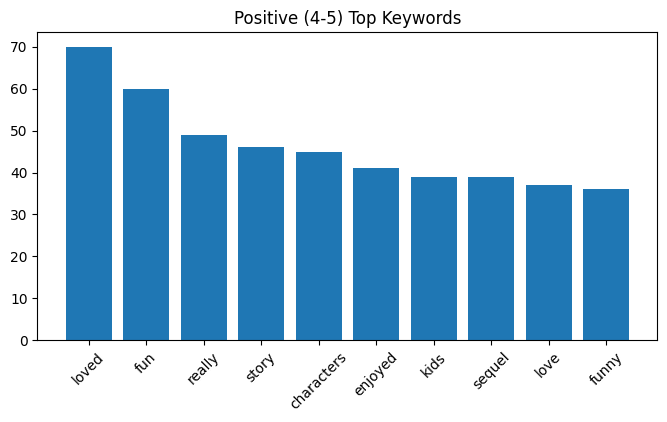

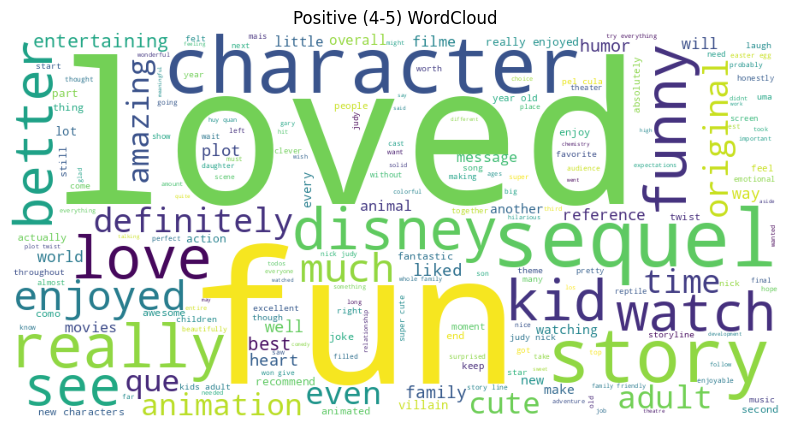


Negative (1-2)
평균 리뷰 길이: 219.6
상위 키워드 10개:
[('though', 4), ('going', 4), ('awful', 4), ('funny', 4), ('action', 4), ('really', 4), ('message', 4), ('bit', 4), ('plot', 4), ('final', 3)]


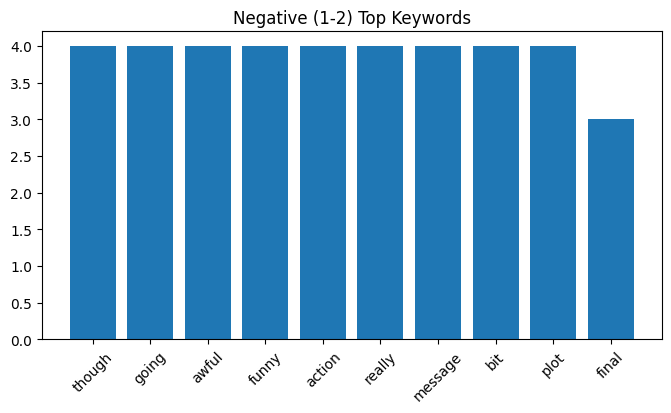

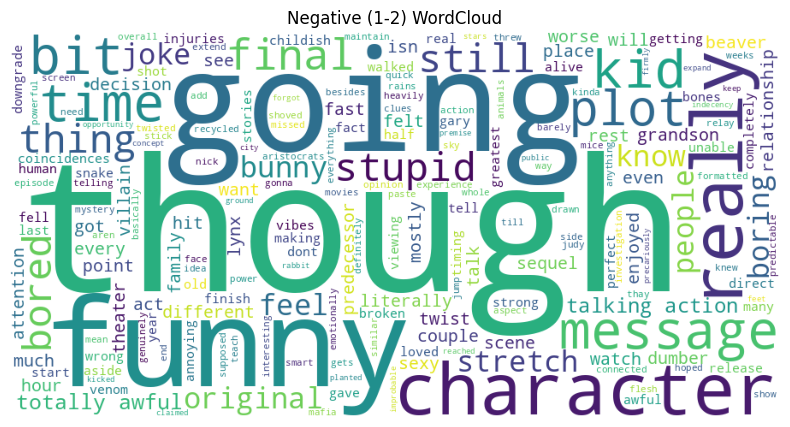

In [36]:
# 함수 실행 예시

review_sentiment_analysis(
    df_review,
    text_col="content_txt",
    rating_col="rating",
    extra_stopwords={"zootopia","good","great","didn","first","don",
                     "bad", "one", "made", "think"},
    movie_name="zootopia"
)


# 실습 과제  

1. 스크래핑 하고싶은 콘텐츠의 리뷰 정보를 최대한 수집
2. 가장 많이 등장한 키워드 추출
3. 콘텐츠의 스토리, 장르가 어떤 키워드 중심인지 파악
4. 감성어, 인물, 단어 등 특징별로 키워드 분류
5. OTT 홍보 전략 목적으로 데이터 분석
6. 데이터 분석 결과 기반 전략 수립 (e.g.) 긍정 키워드를 조합한 홍보전략, 부정 키워드 감지 시스템 등

[실습 예시](https://docs.google.com/presentation/d/1cKHt7KVuCDs45J17R7y9fNpQJO7ypWvf0a3z6ZJEsmo/edit?usp=sharing)